Imports

In [135]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

[[1,2,3,4,5,6,7], [1,2,3,4,5,6,7]]

In [136]:
ds = pd.read_csv('falls_vs_normal.csv')
ds

,xAcc,yAcc,zAcc,xGyro,yGyro,zGyro,label
0,6.99,-0.57,-7.28,-2.75,-3.23,2.62,fall
1,6.51,-0.75,-6.93,-0.67,-6.35,4.64,fall
2,6.22,-0.63,-6.73,0.79,-5.49,3.85,fall
3,6.34,-0.62,-6.80,1.59,-2.26,0.67,fall
4,6.49,-0.39,-6.60,0.67,-0.24,-1.10,fall
...,...,...,...,...,...,...,...
96795,7.30,-1.16,-4.58,18.19,3.60,-35.77,light
96796,7.39,-0.37,-5.05,20.08,0.06,-34.55,light
96797,7.52,-1.46,-5.82,22.58,0.12,-28.02,light
96798,7.58,-2.14,-6.31,19.47,2.44,-22.52,light


In [137]:
import random
print(ds)
def shuffle_data(ds, window_size):
  liste = []
  ds_arr = ds.to_numpy()
  for i in range(0, len(ds_arr), window_size):
    if i % 400 == 0:
      liste.append(ds_arr[i:i+window_size])
  random.shuffle(liste)
  return np.array(liste)
list = shuffle_data(ds, 400)
print(list)
list.shape


       xAcc  yAcc  zAcc  xGyro  yGyro  zGyro  label
0      6.99 -0.57 -7.28  -2.75  -3.23   2.62   fall
1      6.51 -0.75 -6.93  -0.67  -6.35   4.64   fall
2      6.22 -0.63 -6.73   0.79  -5.49   3.85   fall
3      6.34 -0.62 -6.80   1.59  -2.26   0.67   fall
4      6.49 -0.39 -6.60   0.67  -0.24  -1.10   fall
...     ...   ...   ...    ...    ...    ...    ...
96795  7.30 -1.16 -4.58  18.19   3.60 -35.77  light
96796  7.39 -0.37 -5.05  20.08   0.06 -34.55  light
96797  7.52 -1.46 -5.82  22.58   0.12 -28.02  light
96798  7.58 -2.14 -6.31  19.47   2.44 -22.52  light
96799  7.56 -1.90 -5.89  15.56   3.91 -19.23  light

[96800 rows x 7 columns]
[[[5.67 -4.56 -4.62 ... -1.28 -27.16 'fall']
  [4.77 -1.98 -3.85 ... -1.77 -12.51 'fall']
  [6.09 -1.8 -5.93 ... -0.06 12.88 'fall']
  ...
  [5.58 -1.58 8.15 ... -15.14 -12.45 'fall']
  [5.26 -1.67 8.35 ... -15.63 -12.94 'fall']
  [4.92 -2.27 8.28 ... -15.44 -10.99 'fall']]

 [[7.95 -1.28 -4.73 ... 8.67 9.95 'sit']
  [8.39 -2.35 -4.86 ... 6.04 8.97

(242, 400, 7)

In [138]:
samples = []

for sample in list:
  for row in sample:
    samples.append(row)
      
data = pd.DataFrame(samples)
data

,0,1,2,3,4,5,6
0,5.67,-4.56,-4.62,-7.02,-1.28,-27.16,fall
1,4.77,-1.98,-3.85,-15.01,-1.77,-12.51,fall
2,6.09,-1.80,-5.93,-0.43,-0.06,12.88,fall
3,6.44,-3.26,-6.89,-2.69,4.39,14.28,fall
4,7.35,-2.64,-7.18,-1.10,4.70,1.59,fall
...,...,...,...,...,...,...,...
96795,10.94,1.99,-5.10,-15.14,29.17,44.62,step
96796,9.34,0.94,-4.71,-3.97,21.97,29.24,step
96797,6.70,0.09,-3.69,1.16,12.39,9.52,step
96798,4.62,-0.55,-2.39,2.87,6.10,8.61,step


In [139]:

def split_observations(data, window_size):
  ds_arr = data.to_numpy()
  #ds_arr = list
  observations = []
  y_values = []

  for i in range(0, len(ds_arr), window_size):
    observation = ds_arr[i:i + window_size, :-1]  # Slice a window, exclude last col
    observations.append(observation)

    # Append y value every window_size (i.e., every 400 values)
    if i % 400 == 0:  # Check for divisibility by 400, not remainder
      y_value = ds_arr[i, -1]
      # Convert string to 1 if it contains "fall", otherwise 0
      y_value = 1 if "fall" in y_value else 0
      y_values.append(y_value)
      #y_values.append(ds_arr[i, -1])  # Append only the last value of the window

  return np.array(observations), np.array(y_values)
        

In [140]:
WINDOW_SIZE = 400
x, y = split_observations(data, WINDOW_SIZE)
x.shape, y.shape

((242, 400, 6), (242,))

In [141]:
X_train, y_train = x[:200], y[:200]
X_val, y_val = x[200:220], y[200:220]
X_test, y_test = x[220:], y[220:]
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
print(y_train)


[1 0 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 1 1 1 0 0 1 0
 0 0 0 0 1 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1
 0 1 1 0 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0
 1 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0]


In [142]:
from sklearn.preprocessing import LabelEncoder

# Assuming y_train contains string labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)
y_train.shape, y_val.shape, y_test.shape

((200,), (20,), (22,))

In [143]:
# Reshape y_train (and similarly y_val, y_test) for multi-class classification
#y_train = y_train.reshape(y_train.shape[0], 1)
#y_val = y_val.reshape(y_val.shape[0], 1)
#y_test = y_test.reshape(y_test.shape[0], 1)
#y_train.shape, y_val.shape, y_test.shape

In [144]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [145]:
model1 = Sequential()
model1.add(InputLayer((400,6)))
model1.add(LSTM(128, return_sequences=True))
model1.add(LSTM(64, return_sequences=True))
model1.add(LSTM(32, return_sequences=True))
model1.add(LSTM(16))
model1.add(Dense(16, activation='relu'))
model1.add(Dense(1, activation='linear'))
model1.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                  │ (None, 400, 128)       │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 400, 64)        │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 400, 32)        │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_20 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,369 (524.88 KB)

 Trainable params: 134,369 (524.88 KB)

 Non-trainable params: 0 (0.00 B)

In [146]:
cp = ModelCheckpoint('model1/model.keras', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=['Accuracy', 'Precision', 'Recall'])

In [147]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 333ms/step - Accuracy: 0.7074 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.2714 - val_Accuracy: 0.6000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.3207
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 297ms/step - Accuracy: 0.7146 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.2147 - val_Accuracy: 0.6000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.2668
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step - Accuracy: 0.7337 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.1580 - val_Accuracy: 0.6000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.2172
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 298ms/step - Accuracy: 0.7153 - Precision: 0.0000e+00 - Recall: 0.0000e+00 - loss: 0.1418 - val_Accuracy: 0.6000 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_loss: 0.1745
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step - Accuracy: 0.7549 - Precision: 1.0000 - Recall: 0.230

In [148]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/model.keras')

In [149]:
print(len(X_val))
val_predictions = model1.predict(X_val).flatten()
print(val_predictions)
print(len(val_predictions))
print(len(y_val))
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actual':y_val})
val_results

20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
[ 0.12251246  1.0033596   0.720422    0.06341884  0.9976726  -0.04956032
  0.01124914  0.81702596  0.03189334  0.61714303 -0.02903426  0.06525993
  0.38460374 -0.00128085 -0.00495071 -0.01147846 -0.0144963   0.05925512
  0.99262846  0.9853107 ]
20
20


,Val Predictions,Actual
0,0.122512,0
1,1.003360,1
2,0.720422,1
3,0.063419,0
4,0.997673,1
5,-0.049560,0
6,0.011249,0
7,0.817026,1
8,0.031893,0
9,0.617143,1


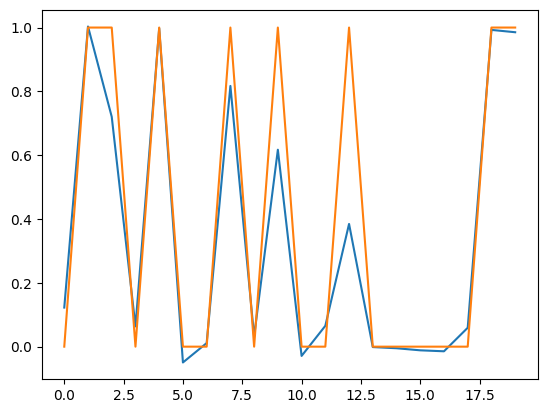

In [150]:
import matplotlib.pyplot as plt
plt.plot(val_results['Val Predictions'][:200])
plt.plot(val_results['Actual'][:200])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step


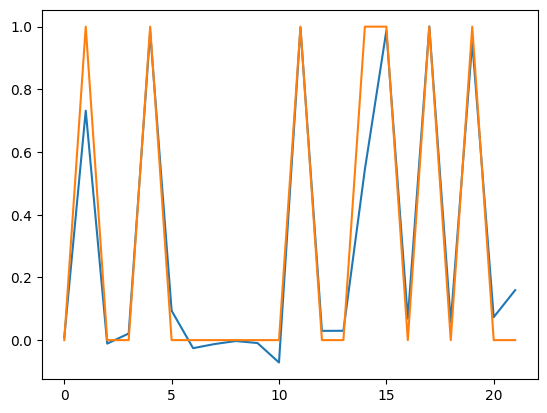

In [151]:
test_predictions = model1.predict(X_test).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actual':y_test})
plt.plot(test_results['Test Predictions'])
plt.plot(test_results['Actual'])